# Group #: Data Story

[AMF] intro to our group's motivation and project

[AMF] describe what the rest of the notebook will contain

In [2]:
%%capture
import importlib

# Check and install torch
if importlib.util.find_spec("torch") is None:
    !pip install torch

# Check and install zarr
if importlib.util.find_spec("zarr") is None:
    !pip install zarr

# Ensure xarray is upgraded
!pip install --upgrade xarray

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import copy as copy
import matplotlib as mpl
import netCDF4 as ncd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as Data
from torch import nn, optim
import matplotlib.cm as cm
import copy as copy
import multiprocessing as mp
from scipy import stats
import time as time
import matplotlib.font_manager
import seaborn as sns
import pandas as pd
from tqdm import tqdm  # Import tqdm for the progress bar
import xarray as xr
import requests

from datetime import datetime
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

today = datetime.today()
torch.cuda.empty_cache()

cwd=os.getcwd()
parent_dir = os.path.dirname(cwd)
os.chdir(parent_dir)
cwd = parent_dir
print("Current working directory:", os.getcwd())

# custom modules
#import lib.func_file as ff
#from lib.visual_figure4 import performance_sigma_point
#from lib.visual_figure3 import score_eval, save_losses_by_seed, plot_n1_scores

np.random.seed(100)

cwd_data = cwd + '/data/'
## 
cwd_output = cwd + '/output/'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Current working directory: /home/jovyan


In [4]:
# Open the dataset from Sane et al. 2023, here stored on the cloud, accessible on LEAP-Pangeo
store = 'https://nyu1.osn.mghpcc.org/leap-pangeo-manual/GOTM/sf_training_data.zarr'
d = xr.open_dataset(store, engine='zarr', chunks={})

# this function calculates the coriolis parameter from input latitude 
# 2*Omega*sin(lat), where Omega is the Earth's rotation in 1/s
def corio(lat):
    return  2*(2*np.pi/(24*60*60)) * np.sin(lat*(np.pi/180))

l0=corio(d['l'][:])
b00=d['b0'][:]
ustar0=d['ustar'][:]
h0=d['h'][:]
lat0=d['lat'][:]
heat0=d['heat'][:]
tx0=d['tx'][:] 
tx0=np.round(tx0,2)
SF0=d['SF'][:] 

# Part 1: Interpretability & Input Features

[PB] work on sorting by latitude

## Mixed Layer Depth

[AMF] paper found greater predictive skill for shallower MLDs, we wondered if we could start to pull apart why from the data. this part of the notebook investigates the strength of correlaiton between feature inputs and diffusivity for shallow MLDs and deeper MLDs.

In [5]:
def correlation_by_depth(depth_min, depth_max):
    d_depth = d.where((d.h.compute() < depth_max) & (d.h.compute() > depth_min), drop=True)
    l0_depth    =corio(d_depth['l'][:])
    b00_depth   =d_depth['b0'][:]
    ustar0_depth=d_depth['ustar'][:]
    h0_depth    =d_depth['h'][:]
    lat0_depth  =d_depth['lat'][:]
    heat0_depth =d_depth['heat'][:]
    tx0_depth   =d_depth['tx'][:] 
    tx0_depth   =np.round(tx0_depth,2)
    SF0_depth   =d_depth['SF'][:] 
    
    data_depth = {
        "l0": l0_depth.values.flatten(),
        "b00": b00_depth.values.flatten(),
        "ustar0": ustar0_depth.values.flatten(),
        "h0": h0_depth.values.flatten(),
    }
    
    for i in range(16):
        data_depth[f"SF0_{i+1}"] = SF0_depth[:, 16-i-1].values.flatten()
    
    df_depth = pd.DataFrame(data_depth)
    correlation_matrix_depth = df_depth.corr()
    sf0_correlation_depth = correlation_matrix_depth.loc["SF0_1":"SF0_16", ["l0", "b00", "ustar0", "h0"]]

    return sf0_correlation_depth

In [40]:
bins = [0,25,50,700]

In [44]:
correlation_0_25 = correlation_by_depth(bins[0],bins[1])
correlation_0_50 = correlation_by_depth(bins[0],bins[2])
correlation_50_700 = correlation_by_depth(bins[2],bins[3])
correlation_0_700 = correlation_by_depth(bins[0],bins[3])

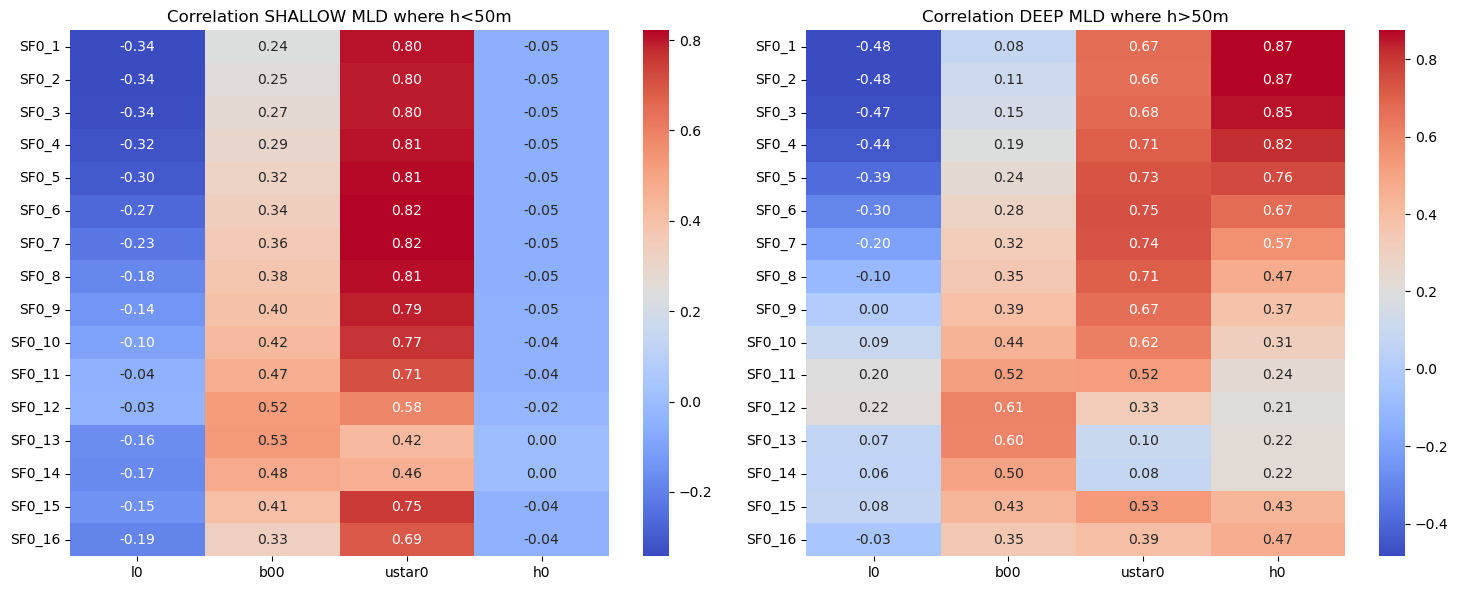

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

sns.heatmap(correlation_0_50, annot=True, cmap="coolwarm", fmt=".2f", cbar=True, ax=axs[0])
axs[0].set_title("Correlation SHALLOW MLD where h<{}m".format(bins[2]))

sns.heatmap(correlation_50_700, annot=True, cmap="coolwarm", fmt=".2f", cbar=True, ax=axs[1])
axs[1].set_title("Correlation DEEP MLD where h>{}m".format(bins[2]))

plt.tight_layout()
plt.show()

[AMF] make comments here on the plots above: what inputs have similar correlations between shallow and deep mixed layers? what inputs look much different? what might this tells us about the data and how different MLD regimes might produce different diffusivity shapes

In [46]:
correlation_0_25_sum = correlation_0_25.abs().sum(axis=1)
correlation_0_50_sum = correlation_0_50.abs().sum(axis=1)
correlation_50_700_sum = correlation_50_700.abs().sum(axis=1)
correlation_0_700_sum = correlation_0_700.abs().sum(axis=1)
y = np.arange(1,17)

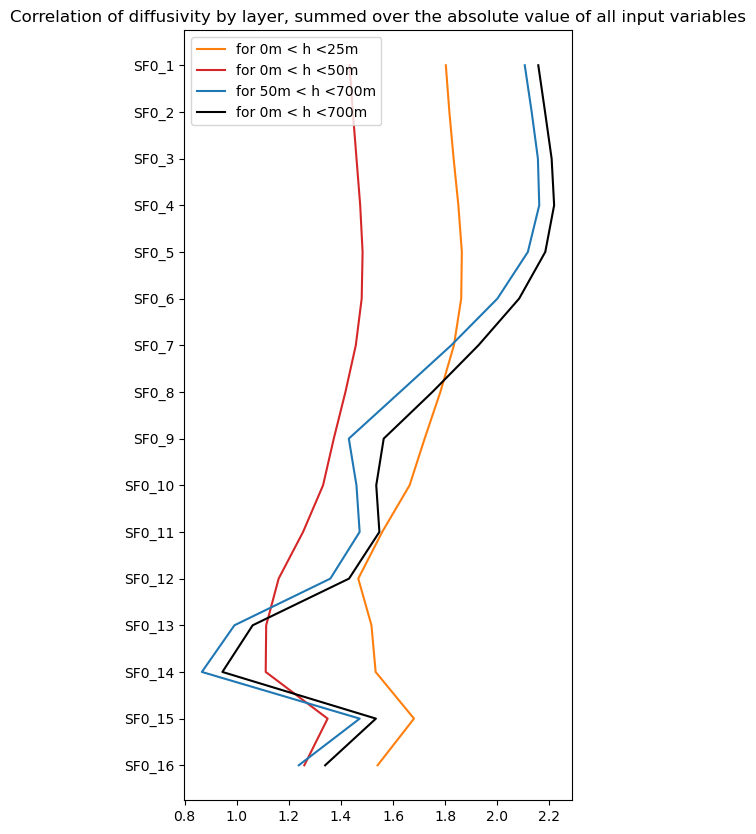

In [50]:
plt.figure(figsize=(5,10))
plt.plot(correlation_0_25_sum, y, label=f"for {bins[0]}m < h <{bins[1]}m", color='tab:orange')
plt.plot(correlation_0_50_sum, y, label=f"for {bins[0]}m < h <{bins[2]}m", color='tab:red')
plt.plot(correlation_50_700_sum, y, label=f"for {bins[2]}m < h <{bins[3]}m", color='tab:blue')
plt.plot(correlation_0_700_sum, y, label=f"for {bins[0]}m < h <{bins[3]}m", color='k')
plt.gca().invert_yaxis()
plt.legend()
plt.yticks(ticks=np.arange(1,17,1),labels=['SF0_1','SF0_2','SF0_3','SF0_4','SF0_5','SF0_6','SF0_7','SF0_8','SF0_9','SF0_10','SF0_11','SF0_12','SF0_13','SF0_14','SF0_15','SF0_16']);
plt.title('Correlation of diffusivity by layer, summed over the absolute value of all input variables');

[AMF] make comments on the above plots: where is summed correlation the highest? the lowest? how do shallow mixed layers compare to deeper ones? relate this back to skillfulness of shape prediction somehow

# Part 2: Model Improvement

[CL] work on step-by-step model architecture

[BH] work on XGBoost model? (if it seems like it's training)